In [44]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam
from sklearn.svm import OneClassSVM
import matplotlib.pyplot as plt

# Function to evaluate model performance
def evaluate_model(true_labels, predicted_labels):
    tn, fp, fn, tp = confusion_matrix(true_labels, predicted_labels).ravel()
    accuracy = accuracy_score(true_labels, predicted_labels)
    f1 = 2 * tp / (2 * tp + fp + fn) if (tp + fn) > 0 else 0
    percent_errors_identified = (tp / (tp + fn)) * 100 if (tp + fn) > 0 else 0
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"Percentage of Errors Correctly Identified: {percent_errors_identified:.2f}%")
    return accuracy, f1, percent_errors_identified


# Load dataset
df = pd.read_csv(r"C:/Users/twool/Downloads/intersection_analysis_2D.csv")

# Print dataset head for debugging
print(df.head())

# Convert is_point columns from TRUE/FALSE to 1/0
df.replace({"TRUE": 1, "FALSE": 0, True: 1, False: 0}, inplace=True)

# Undersample label 0, keep all label 1
target_col = "error"
label_0 = df[df[target_col] == 0]
label_1 = df[df[target_col] == 1]

# Randomly sample 10,000 from label 0
label_0_sampled = label_0.sample(n=10000, random_state=42)
df_balanced = pd.concat([label_0_sampled, label_1], ignore_index=True)

# Shuffle the balanced dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Identify features and target
ignore_cols = ["geometry"]
print("Dataset preview:")
features = df_balanced.drop(columns=ignore_cols + [target_col])
target = df_balanced[target_col]

# Standardize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)


# Method 1: One-Class Neural Network (Autoencoder)
def one_class_nn_method(features_scaled, target):
    input_dim = features_scaled.shape[1]
    inputs = Input(shape=(input_dim,))
    encoded = Dense(300, activation='relu')(inputs)
    decoded = Dense(input_dim, activation='sigmoid')(encoded)
    
    autoencoder = Model(inputs, decoded)
    autoencoder.compile(optimizer=Adam(), loss='mean_squared_error')

    # Train autoencoder in an unsupervised way
    autoencoder.fit(features_scaled, features_scaled, epochs=50, batch_size=256, shuffle=True)
    
    # Compute reconstruction error
    reconstruction = autoencoder.predict(features_scaled)
    mse = np.mean(np.power(features_scaled - reconstruction, 2), axis=1)

    # Set threshold for anomalies (95th percentile of reconstruction error)
    threshold = np.percentile(mse, 93)
    y_pred = (mse > threshold).astype(int)

    print("\nOne-Class NN Evaluation:")
    return evaluate_model(target, y_pred)


# Method 2: Variational Autoencoder (VAE) - Simplified
def vae_method(features_scaled, target):
    input_dim = features_scaled.shape[1]
    inputs = Input(shape=(input_dim,))
    encoded = Dense(300, activation='relu')(inputs)
    decoded = Dense(input_dim, activation='sigmoid')(encoded)
    
    vae = Model(inputs, decoded)
    vae.compile(optimizer=Adam(), loss='mean_squared_error')

    # Train VAE in an unsupervised way
    vae.fit(features_scaled, features_scaled, epochs=50, batch_size=256, shuffle=True)
    
    # Compute reconstruction error
    reconstruction = vae.predict(features_scaled)
    mse = np.mean(np.power(features_scaled - reconstruction, 2), axis=1)

    # Set threshold for anomalies (95th percentile)
    threshold = np.percentile(mse, 95)
    y_pred = (mse > threshold).astype(int)

    print("\nVAE Evaluation:")
    return evaluate_model(target, y_pred)


# Method 3: One-Class SVM
def one_class_svm_method(features_scaled, target, nu=0.05):
    svm = OneClassSVM(nu=nu, kernel="rbf")
    svm.fit(features_scaled)

    # Predict anomalies (-1 means outlier)
    preds = svm.predict(features_scaled)
    y_pred = (preds == -1).astype(int)

    print("\nOne-Class SVM Evaluation:")
    return evaluate_model(target, y_pred)


# Run each method
one_class_nn_method(features_scaled, target)
vae_method(features_scaled, target)
one_class_svm_method(features_scaled, target)


                          geometry  num_of_lines  avg_angle_of_intersection  \
0    POINT (30.1132479 81.9040127)             3                   1.569418   
1  POINT (30.11393889 81.90421187)             3                   0.000869   
2  POINT (30.13443475 81.92446576)             3                   0.000869   
3  POINT (30.12866542 81.91527886)             3                   0.001507   
4  POINT (30.10870486 81.90333917)             4                   2.092366   

   num_of_involved_line_intersections  \
0                                  20   
1                                  16   
2                                  16   
3                                  20   
4                                   7   

   vicinity_of_involved_line_intersections  min_distance_to_endpoint  \
0                                 0.006751                 30.167739   
1                                 0.005855                 30.168430   
2                                 0.025495                 30.

(0.9276252639662124, 0.19787234042553192, 22.248803827751196)

                          geometry  num_of_lines  avg_angle_of_intersection  \
0    POINT (30.1132479 81.9040127)             3                   1.569418   
1  POINT (30.11393889 81.90421187)             3                   0.000869   
2  POINT (30.13443475 81.92446576)             3                   0.000869   
3  POINT (30.12866542 81.91527886)             3                   0.001507   
4  POINT (30.10870486 81.90333917)             4                   2.092366   

   num_of_involved_line_intersections  \
0                                  20   
1                                  16   
2                                  16   
3                                  20   
4                                   7   

   vicinity_of_involved_line_intersections  min_distance_to_endpoint  \
0                                 0.006751                 30.167739   
1                                 0.005855                 30.168430   
2                                 0.025495                 30.

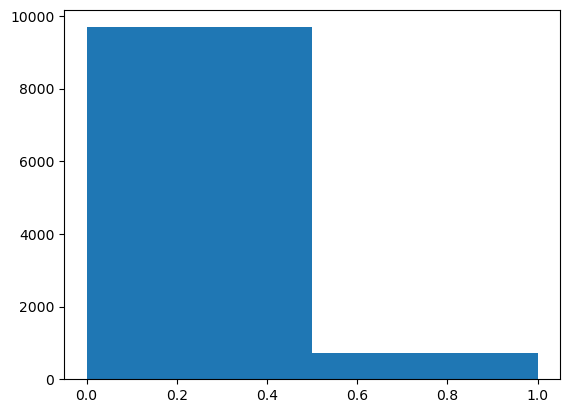

In [45]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv(r"C:/Users/twool/Downloads/intersection_analysis_2D.csv")

# Print dataset head for debugging
print(df.head())

# Convert is_point columns from TRUE/FALSE to 1/0
df.replace({"TRUE": 1, "FALSE": 0, True: 1, False: 0}, inplace=True)

# Undersample label 0, keep all label 1
target_col = "error"
label_0 = df[df[target_col] == 0]
label_1 = df[df[target_col] == 1]

# Randomly sample 10,000 from label 0
label_0_sampled = label_0.sample(n=10000, random_state=42)
df_balanced = pd.concat([label_0_sampled, label_1], ignore_index=True)

# Shuffle the balanced dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Identify features and target
ignore_cols = ["geometry"]
print("Dataset preview:")
features = df_balanced.drop(columns=ignore_cols + [target_col])
target = df_balanced[target_col]

# Standardize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

input_dim = features_scaled.shape[1]  # Set dynamically


# Generator Network
def build_generator(input_dim, output_dim):
    inputs = Input(shape=(input_dim,))
    x = Dense(128)(inputs)
    x = LeakyReLU(0.2)(x)
    x = BatchNormalization()(x)
    x = Dense(264)(x)
    x = LeakyReLU(0.2)(x)
    x = BatchNormalization()(x)
    x = Dense(output_dim, activation='tanh')(x)
    return Model(inputs, x)


# Discriminator Network
def build_discriminator(input_dim):
    inputs = Input(shape=(input_dim,))
    x = Dense(264)(inputs)
    x = LeakyReLU(0.2)(x)
    x = Dense(128)(x)
    x = LeakyReLU(0.2)(x)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, x)
    model.compile(optimizer=Adam(0.002), loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Compile GAN
def build_gan(generator, discriminator):
    discriminator.trainable = False  # Freeze discriminator during GAN training
    inputs = Input(shape=(generator.input_shape[1],))
    generated_data = generator(inputs)
    outputs = discriminator(generated_data)
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(0.002), loss='binary_crossentropy')
    return model


# Train GAN
def train_gan(generator, discriminator, gan, data, epochs=500, batch_size=64):
    half_batch = batch_size // 2
    for epoch in range(epochs):
        # Train discriminator
        discriminator.trainable = True  # Unfreeze for training
        real_data = data[np.random.randint(0, data.shape[0], half_batch)]
        noise = np.random.randn(half_batch, generator.input_shape[1])
        fake_data = generator.predict(noise)

        d_loss_real = discriminator.train_on_batch(real_data, np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(fake_data, np.zeros((half_batch, 1)))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train generator
        discriminator.trainable = False  # Freeze again before GAN training
        noise = np.random.randn(batch_size, generator.input_shape[1])
        g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

        if epoch % 100 == 0:
            d_loss_value = float(np.mean(d_loss))  # Ensure it's a scalar
            g_loss_value = float(np.mean(g_loss))  # Ensure it's a scalar
            print(f"Epoch {epoch}: D Loss={d_loss_value:.4f}, G Loss={g_loss_value:.4f}")


# Anomaly detection using GAN reconstruction error
def detect_anomalies(generator, features_scaled):
    noise = np.random.randn(len(features_scaled), generator.input_shape[1])
    reconstructed = generator.predict(noise)
    mse = np.mean(np.power(features_scaled - reconstructed, 2), axis=1)

    # Set threshold at 95th percentile
    threshold = np.percentile(mse, 93)
    anomaly_labels = (mse > threshold).astype(int)
    
    return anomaly_labels


# Build & train GAN
generator = build_generator(input_dim, input_dim)  # Input and output dimensions match
discriminator = build_discriminator(input_dim)
gan = build_gan(generator, discriminator)

train_gan(generator, discriminator, gan, features_scaled, epochs=2000, batch_size=128)

# Detect anomalies
detected_anomalies = detect_anomalies(generator, features_scaled)

# Evaluate model (labels only used here)
conf_matrix = confusion_matrix(target, detected_anomalies)
print("Confusion Matrix:\n", conf_matrix)
plt.hist(detected_anomalies, bins=2)
plt.show()


Epoch 1/200

40/40 [==============================] - 1s 2ms/step - loss: 1.3475
Epoch 2/200

40/40 [==============================] - 0s 2ms/step - loss: 1.0491
Epoch 3/200

40/40 [==============================] - 0s 2ms/step - loss: 0.9431
Epoch 4/200

40/40 [==============================] - 0s 2ms/step - loss: 0.9038
Epoch 5/200

40/40 [==============================] - 0s 2ms/step - loss: 0.8861
Epoch 6/200

40/40 [==============================] - 0s 2ms/step - loss: 0.8765
Epoch 7/200

40/40 [==============================] - 0s 2ms/step - loss: 0.8707
Epoch 8/200

40/40 [==============================] - 0s 2ms/step - loss: 0.8669
Epoch 9/200

40/40 [==============================] - 0s 2ms/step - loss: 0.8642
Epoch 10/200

40/40 [==============================] - 0s 2ms/step - loss: 0.8622
Epoch 11/200

40/40 [==============================] - 0s 2ms/step - loss: 0.8608
Epoch 12/200

40/40 [==============================] - 0s 2ms/step - loss: 0.8596
Epoch 13/200

40/40 [====

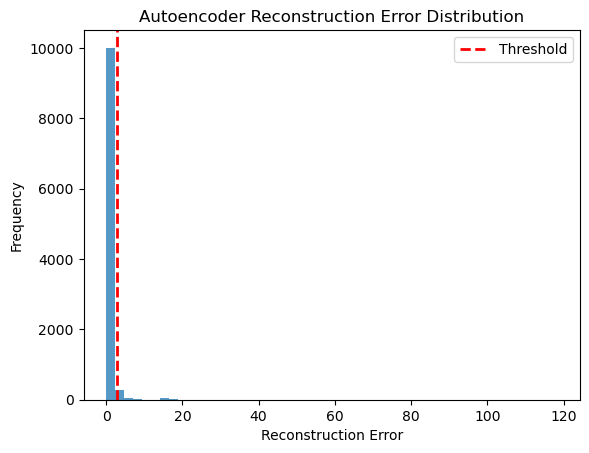

In [46]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc
import matplotlib.pyplot as plt



# Dimensionality Reduction with PCA
pca = PCA(n_components=0.95)  # Keep 95% variance
features_pca = pca.fit_transform(features_scaled)

# Train Autoencoder on Normal Data (target = 0)
normal_data = features_pca[target == 0]
input_dim = normal_data.shape[1]

inputs = Input(shape=(input_dim,))
encoded = Dense(264, activation='relu')(inputs)
decoded = Dense(input_dim, activation='sigmoid')(encoded)
autoencoder = Model(inputs, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

autoencoder.fit(normal_data, normal_data, epochs=200, batch_size=256, shuffle=True)

# Compute Reconstruction Error
reconstructed = autoencoder.predict(features_pca)
mse = np.mean(np.power(features_pca - reconstructed, 2), axis=1)

# Dynamic Threshold using IQR
q1, q3 = np.percentile(mse, [10, 90])
iqr = q3 - q1
threshold = q3 + 1.5 * iqr
y_pred_autoencoder = (mse > threshold).astype(int)

# Isolation Forest
iso_forest = IsolationForest(contamination=0.1)
y_pred_iso = iso_forest.fit_predict(features_pca)
y_pred_iso = np.where(y_pred_iso == 1, 0, 1)  # Convert -1 (anomaly) to 1

# One-Class SVM
oc_svm = OneClassSVM(nu=0.1)
y_pred_svm = oc_svm.fit_predict(features_pca)
y_pred_svm = np.where(y_pred_svm == 1, 0, 1)

# Evaluate Models
def evaluate_model(true_labels, predicted_labels, model_name):
    cm = confusion_matrix(true_labels, predicted_labels)
    precision, recall, _ = precision_recall_curve(true_labels, predicted_labels)
    pr_auc = auc(recall, precision)
    percent_errors_identified = cm[1, 1] / (cm[1, 1] + cm[1, 0]) * 100
    print(f"\n{model_name} Results:")
    print("Confusion Matrix:")
    print(cm)
    print(f"Precision-Recall AUC: {pr_auc:.4f}")
    print(f"Percentage of Errors Identified: {percent_errors_identified:.2f}%")
    return pr_auc, percent_errors_identified

# Run Evaluations
evaluate_model(target, y_pred_autoencoder, "Autoencoder")
evaluate_model(target, y_pred_iso, "Isolation Forest")
evaluate_model(target, y_pred_svm, "One-Class SVM")

# Plot Reconstruction Error Distribution
plt.hist(mse, bins=50, alpha=0.75)
plt.axvline(threshold, color='red', linestyle='dashed', linewidth=2, label='Threshold')
plt.legend()
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.title("Autoencoder Reconstruction Error Distribution")
plt.show()


In [47]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix



# Convert to PyTorch tensors
tensor_data = torch.tensor(features_scaled, dtype=torch.float32)
target_tensor = torch.tensor(target.values, dtype=torch.float32)

# DataLoader for batching
data_loader = DataLoader(TensorDataset(tensor_data, target_tensor), batch_size=64, shuffle=True)

# Define Transformer Model
class TransformerAnomalyDetector(nn.Module):
    def __init__(self, input_dim, num_heads=4, num_layers=2, hidden_dim=64):
        super(TransformerAnomalyDetector, self).__init__()

        # Use Linear Layer to adjust input dimension to be divisible by num_heads
        adjusted_input_dim = (input_dim // num_heads + 1) * num_heads
        self.input_adjuster = nn.Linear(input_dim, adjusted_input_dim)

        self.encoder_layer = nn.TransformerEncoderLayer(d_model=adjusted_input_dim, nhead=num_heads)
        self.transformer = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(adjusted_input_dim, 1)
    
    def forward(self, x):
        x = self.input_adjuster(x)  # Adjust input dimension
        x = self.transformer(x.unsqueeze(1))  # Add batch dimension and pass through transformer
        x = self.fc(x[:, -1, :])  # Take last time step's output
        return x.squeeze()

# Initialize model
input_dim = features_scaled.shape[1]
model = TransformerAnomalyDetector(input_dim)

# Training setup
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model(model, data_loader, epochs=100):
    model.train()
    for epoch in range(epochs):
        for batch in data_loader:
            inputs, labels = batch
            optimizer.zero_grad()
            outputs = model(inputs)  # No need for unsqueeze here
            loss = criterion(outputs, inputs.mean(dim=1))  # Compare output to mean of input as a simple anomaly score
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

# Train the transformer model
train_model(model, data_loader)

# Generate anomaly scores
model.eval()
with torch.no_grad():
    anomaly_scores = model(tensor_data).numpy()

# Set threshold dynamically (e.g., top 5% anomalies)
threshold = np.percentile(anomaly_scores, 95)
predictions = (anomaly_scores > threshold).astype(int)

# Evaluate performance
tn, fp, fn, tp = confusion_matrix(target, predictions).ravel()
print(f"True Negatives: {tn}, False Positives: {fp}, False Negatives: {fn}, True Positives: {tp}")
print(f"Precision: {tp / (tp + fp):.2f}, Recall: {tp / (tp + fn):.2f}")


Epoch 1, Loss: 0.0095
Epoch 2, Loss: 0.0046
Epoch 3, Loss: 0.0039
Epoch 4, Loss: 0.0079
Epoch 5, Loss: 0.0084
Epoch 6, Loss: 0.0025
Epoch 7, Loss: 0.0042
Epoch 8, Loss: 0.0031
Epoch 9, Loss: 0.0294
Epoch 10, Loss: 0.0023
Epoch 11, Loss: 0.0021
Epoch 12, Loss: 0.0036
Epoch 13, Loss: 0.0491
Epoch 14, Loss: 0.0036
Epoch 15, Loss: 0.0037
Epoch 16, Loss: 0.0068
Epoch 17, Loss: 0.0015
Epoch 18, Loss: 0.0015
Epoch 19, Loss: 0.0022
Epoch 20, Loss: 0.0022
Epoch 21, Loss: 0.0028
Epoch 22, Loss: 0.0052
Epoch 23, Loss: 0.0016
Epoch 24, Loss: 0.0015
Epoch 25, Loss: 0.0030
Epoch 26, Loss: 0.0008
Epoch 27, Loss: 0.0014
Epoch 28, Loss: 0.0012
Epoch 29, Loss: 0.0024
Epoch 30, Loss: 0.0023
Epoch 31, Loss: 0.0014
Epoch 32, Loss: 0.0010
Epoch 33, Loss: 0.0015
Epoch 34, Loss: 0.0012
Epoch 35, Loss: 0.0006
Epoch 36, Loss: 0.0009
Epoch 37, Loss: 0.0031
Epoch 38, Loss: 0.0005
Epoch 39, Loss: 0.0007
Epoch 40, Loss: 0.0020
Epoch 41, Loss: 0.0014
Epoch 42, Loss: 0.0002
Epoch 43, Loss: 0.0014
Epoch 44, Loss: 0.00

In [53]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope
from sklearn.decomposition import PCA



# 1. CBLOF (Cluster-Based Local Outlier Factor)
# Since CBLOF is a hybrid model, we can try a basic method using clustering and distance to centroids.
from sklearn.cluster import KMeans

def cblof(features, contamination=0.1):
    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=3)  # You can adjust the number of clusters based on your data
    kmeans.fit(features)
    centroids = kmeans.cluster_centers_
    
    # Calculate distance from each point to the nearest centroid
    distances = np.min(np.linalg.norm(features - centroids[:, np.newaxis], axis=2), axis=0)
    
    # Determine the threshold based on contamination rate (top percentage of points with the largest distance)
    threshold = np.percentile(distances, 100 * (1 - contamination))
    
    # Mark as outliers those points that are further than the threshold
    predictions = (distances > threshold).astype(int)
    
    return predictions

cblof_predictions = cblof(features_scaled, contamination=0.1)

# 2. HBOS (Histogram-Based Outlier Score)
# HBOS can be approximated by checking if points fall in the extreme tails of the distribution.
def hbos(features, contamination=0.1):
    # Apply PCA for dimensionality reduction before applying histogram method
    pca = PCA(n_components=1)  # Reduce to 1D for simplicity (you can change the number of components)
    features_reduced = pca.fit_transform(features)
    
    # Calculate histogram and density
    hist, bins = np.histogram(features_reduced, bins=30, density=True)
    
    # Get the threshold based on the contamination rate
    threshold = np.percentile(features_reduced, 100 * (1 - contamination))
    
    # Mark outliers as those that fall outside the threshold
    predictions = (features_reduced < threshold).astype(int)
    
    return predictions

hbos_predictions = hbos(features_scaled, contamination=0.1)

# 3. Elliptic Envelope (Based on Gaussian distribution)
elliptic_model = EllipticEnvelope(contamination=0.1)
elliptic_model.fit(features_scaled)
elliptic_predictions = elliptic_model.predict(features_scaled)
elliptic_predicted_labels = (elliptic_predictions == -1).astype(int)

# Evaluate results using confusion matrix (only for evaluation)
print("Confusion Matrix for CBLOF:")
cm_cblof = confusion_matrix(target, cblof_predictions)
print(cm_cblof)

print("\nConfusion Matrix for HBOS:")
cm_hbos = confusion_matrix(target, hbos_predictions)
print(cm_hbos)

print("\nConfusion Matrix for Elliptic Envelope:")
cm_elliptic = confusion_matrix(target, elliptic_predicted_labels)
print(cm_elliptic)


C:\Users\twool\AppData\Local\ESRI\conda\envs\arcgispro-py3-clone\Lib\site-packages\sklearn\covariance\_robust_covariance.py:186: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-70.464720802090824 > -91.665270352754618). You may want to try with a higher value of support_fraction (current value: 0.501).
  warnings.warn(
C:\Users\twool\AppData\Local\ESRI\conda\envs\arcgispro-py3-clone\Lib\site-packages\sklearn\covariance\_robust_covariance.py:186: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-70.464720802090824 > -91.665270352754618). You may want to try with a higher value of support_fraction (current value: 0.501).
  warnings.warn(
C:\Users\twool\AppData\Local\ESRI\conda\envs\arcgispro-py3-clone\Lib\site-packages\sklearn\covariance\_robust_covariance.py:186: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-70.464720802090824 > -91.665270

Confusion Matrix for CBLOF:
[[9100  900]
 [ 276  142]]

Confusion Matrix for HBOS:
[[ 859 9141]
 [ 183  235]]

Confusion Matrix for Elliptic Envelope:
[[9045  955]
 [ 331   87]]


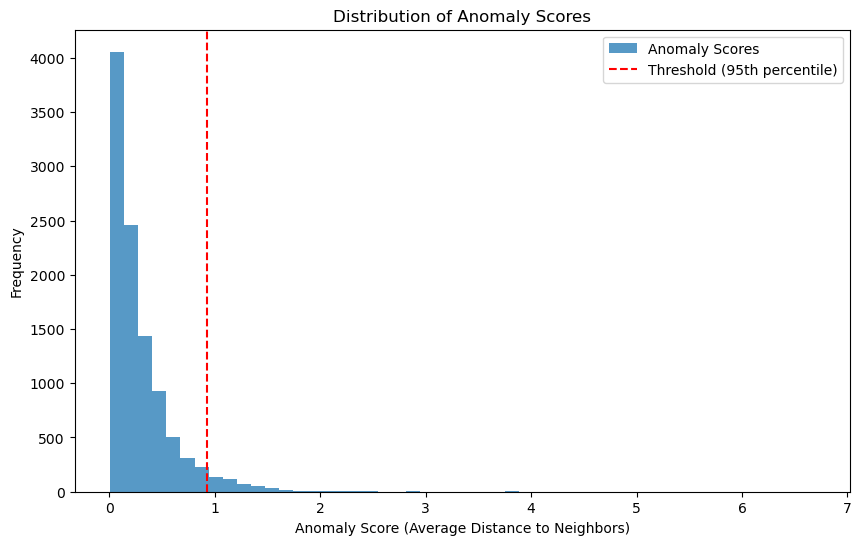

Precision: 0.1094
Recall: 0.1364
F1-Score: 0.1214


In [54]:
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

# Fit KNN (unsupervised) to the data
knn = NearestNeighbors(n_neighbors=5)  # You can change the number of neighbors
knn.fit(features_scaled)

# Compute the distance to the nearest neighbors for each point
distances, indices = knn.kneighbors(features_scaled)

# Calculate the average distance to the nearest neighbors (anomaly score)
anomaly_scores = distances.mean(axis=1)

# Define an anomaly threshold (e.g., 95th percentile of distances)
threshold = np.percentile(anomaly_scores, 95)  # Anomaly threshold (top 5% most distant points)
predictions = (anomaly_scores > threshold).astype(int)  # 1 for anomaly, 0 for normal

# Evaluate performance with a plot
plt.figure(figsize=(10, 6))
plt.hist(anomaly_scores, bins=50, alpha=0.75, label='Anomaly Scores')
plt.axvline(x=threshold, color='red', linestyle='--', label=f"Threshold (95th percentile)")
plt.xlabel('Anomaly Score (Average Distance to Neighbors)')
plt.ylabel('Frequency')
plt.title('Distribution of Anomaly Scores')
plt.legend()
plt.show()

# Calculate precision, recall, and F1-score if labels are available
if target_col in df.columns:    
    # Calculate precision, recall, and F1-score
    precision = precision_score(target, predictions)
    recall = recall_score(target, predictions)
    f1 = f1_score(target, predictions)
    
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
else:
    print("No target column available for comparison.")


In [55]:
# Load dataset
df = pd.read_csv(r"C:/Users/twool/Downloads/intersection_analysis_2D.csv") 

# Print dataset head for debugging
print("Dataset preview:")
print(df.head())

# Convert is_point columns from TRUE/FALSE to 1/0
df.replace({"TRUE": 1, "FALSE": 0, True: 1, False: 0}, inplace=True)

# Undersample label 0, keep all label 1
target_col = "error"
label_0 = df[df[target_col] == 0]
label_1 = df[df[target_col] == 1]

# Randomly sample 10,000 from label 0
label_0_sampled = label_0.sample(n=10000, random_state=42)
df_balanced = pd.concat([label_0_sampled, label_1], ignore_index=True)

# Shuffle the balanced dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Identify features and target
ignore_cols = ["geometry"]
features = df_balanced.drop(columns=ignore_cols + [target_col])
target = df_balanced[target_col]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Print dataset statistics
print("\nTraining set:")
print(f"Total data points: {len(y_train)}")
print(y_train.value_counts(normalize=True) * 100)

print("\nTest set:")
print(f"Total data points: {len(y_test)}")
print(y_test.value_counts(normalize=True) * 100)

# Standardize features for SVM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Dataset preview:
                          geometry  num_of_lines  avg_angle_of_intersection  \
0    POINT (30.1132479 81.9040127)             3                   1.569418   
1  POINT (30.11393889 81.90421187)             3                   0.000869   
2  POINT (30.13443475 81.92446576)             3                   0.000869   
3  POINT (30.12866542 81.91527886)             3                   0.001507   
4  POINT (30.10870486 81.90333917)             4                   2.092366   

   num_of_involved_line_intersections  \
0                                  20   
1                                  16   
2                                  16   
3                                  20   
4                                   7   

   vicinity_of_involved_line_intersections  min_distance_to_endpoint  \
0                                 0.006751                 30.167739   
1                                 0.005855                 30.168430   
2                                 0.025495   

In [56]:
from sklearn.semi_supervised import LabelSpreading
from sklearn.metrics import classification_report, confusion_matrix

# Mark a portion of y_train as unlabeled (-1)
import numpy as np

# Use only 10% of labels in training set
num_labeled = int(0.1 * len(y_train))
y_train_semi = np.copy(y_train.values)
y_train_semi[num_labeled:] = -1  # Unlabeled data

# Label Spreading model
label_spread = LabelSpreading(kernel='knn', n_neighbors=7, alpha=0.2)
label_spread.fit(X_train_scaled, y_train_semi)

# Predict on test set
y_pred = label_spread.predict(X_test_scaled)

# Evaluation
print("\n[Label Spreading Evaluation]")
print("Accuracy:", (y_pred == y_test.values).mean())
print("Classification Report:\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)


C:\Users\twool\AppData\Local\ESRI\conda\envs\arcgispro-py3-clone\Lib\site-packages\sklearn\semi_supervised\_label_propagation.py:230: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer



[Label Spreading Evaluation]
Accuracy: 0.9400191938579654
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      1994
           1       0.28      0.26      0.27        90

    accuracy                           0.94      2084
   macro avg       0.63      0.61      0.62      2084
weighted avg       0.94      0.94      0.94      2084

Confusion Matrix:
 [[1936   58]
 [  67   23]]


In [57]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.semi_supervised import SelfTrainingClassifier

# Base classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Mark some labels as -1 (unlabeled)
y_train_semi = np.copy(y_train.values)
y_train_semi[num_labeled:] = -1  # Mark 90% as unlabeled

# Self-training
self_training = SelfTrainingClassifier(rf, threshold=0.8, verbose=True)
self_training.fit(X_train_scaled, y_train_semi)

# Predict and evaluate
y_pred = self_training.predict(X_test_scaled)

print("\n[Self-Training with RF Evaluation]")
print("Accuracy:", (y_pred == y_test.values).mean())
print("Classification Report:\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)


End of iteration 1, added 7079 new labels.
End of iteration 2, added 263 new labels.
End of iteration 3, added 52 new labels.
End of iteration 4, added 19 new labels.
End of iteration 5, added 3 new labels.
End of iteration 6, added 2 new labels.
End of iteration 7, added 1 new labels.
End of iteration 8, added 2 new labels.
End of iteration 9, added 2 new labels.

[Self-Training with RF Evaluation]
Accuracy: 0.9654510556621881
Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98      1994
           1       1.00      0.20      0.33        90

    accuracy                           0.97      2084
   macro avg       0.98      0.60      0.66      2084
weighted avg       0.97      0.97      0.95      2084

Confusion Matrix:
 [[1994    0]
 [  72   18]]


In [58]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.semi_supervised import LabelSpreading, SelfTrainingClassifier
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Only use 10% of training data as labeled
labeled_ratio = 0.1
num_labeled = int(labeled_ratio * len(y_train))

# Split labeled/unlabeled
X_labeled = X_train.iloc[:num_labeled]
y_labeled = y_train.iloc[:num_labeled]
X_unlabeled = X_train.iloc[num_labeled:]
y_unlabeled = y_train.iloc[num_labeled:]  # For evaluation/reference

# === Apply SMOTE to labeled data only ===
print("Before SMOTE:", y_labeled.value_counts())
smote = SMOTE(random_state=42)
X_labeled_resampled, y_labeled_resampled = smote.fit_resample(X_labeled, y_labeled)
print("After SMOTE:", np.bincount(y_labeled_resampled))

# === Combine labeled + unlabeled (mark unlabeled as -1) ===
X_train_combined = pd.concat([pd.DataFrame(X_labeled_resampled), X_unlabeled], ignore_index=True)
y_train_combined = np.concatenate([y_labeled_resampled, [-1] * len(X_unlabeled)])

# === Scale full train/test set ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_combined)
X_test_scaled = scaler.transform(X_test)

# ==========================================
# Method 1: Label Spreading
# ==========================================
print("\n=== Label Spreading with SMOTE-labeled data ===")
label_spread = LabelSpreading(kernel='knn', n_neighbors=7)
label_spread.fit(X_train_scaled, y_train_combined)
y_pred_ls = label_spread.predict(X_test_scaled)

print("Accuracy:", (y_pred_ls == y_test.values).mean())
print("Classification Report:\n", classification_report(y_test, y_pred_ls))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_ls))

# ==========================================
# Method 2: Self-training (Random Forest)
# ==========================================
print("\n=== Self-training with SMOTE-labeled data ===")
rf = RandomForestClassifier(n_estimators=100, random_state=42)
self_training = SelfTrainingClassifier(rf, threshold=0.8)
self_training.fit(X_train_scaled, y_train_combined)
y_pred_rf = self_training.predict(X_test_scaled)

print("Accuracy:", (y_pred_rf == y_test.values).mean())
print("Classification Report:\n", classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))


Before SMOTE: error
0    802
1     31
Name: count, dtype: int64
After SMOTE: [802 802]

=== Label Spreading with SMOTE-labeled data ===


C:\Users\twool\AppData\Local\ESRI\conda\envs\arcgispro-py3-clone\Lib\site-packages\sklearn\semi_supervised\_label_propagation.py:230: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


Accuracy: 0.9222648752399232
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.95      0.96      1994
           1       0.22      0.32      0.26        90

    accuracy                           0.92      2084
   macro avg       0.60      0.64      0.61      2084
weighted avg       0.94      0.92      0.93      2084

Confusion Matrix:
 [[1893  101]
 [  61   29]]

=== Self-training with SMOTE-labeled data ===
Accuracy: 0.9529750479846449
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.98      1994
           1       0.44      0.36      0.40        90

    accuracy                           0.95      2084
   macro avg       0.71      0.67      0.69      2084
weighted avg       0.95      0.95      0.95      2084

Confusion Matrix:
 [[1954   40]
 [  58   32]]
